# Week 7 - Community Detection 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import networkx as nx

%matplotlib inline

## Exercise 1: Programming Modularity

In this exercise, we will implement modularity and spectral modularity.
If we assume two partitions described by indicator-vector $s \in \{-1, 1\}^n$ where $s_i$ is $-1$ if node $i$ is in one group and $1$ if it is in the other, 
then we can formulate modularity as

$$ 
Q(G, S) = \frac{1}{2 m} \sum_{i, j \in V}\left(A_{ij}-\frac{k_{i} k_{j}}{2 m}\right) \frac{1}{2}(s_i s_j + 1)\\
= \frac{1}{4m} \sum_{i, j \in V} \left( A_{ij} - \frac{k_i k_j}{2m} \right) s_i s_j \\
\propto s^T B s\qquad \qquad \qquad \qquad \\
= \sum_{i}(u_i^T s)^2 \beta_i \qquad \qquad
$$ 

where $S$ is the set of clusters in the graph, $A$ is the adjacency matrix, and $k_i$ is the expected number of edges of node $i$ and
$B_{ij} = A_{ij} - \frac{k_i k_j}{2m}$ and $u_i$ ($\beta_i$) are eigenvectors (eigenvalues) of $B$.

In [15]:
def M_eq(G: nx.Graph, s):
    """
        args:
            G: an Networkx graph
            s: an indicatorvector of {-1, 1} indicating which cluster each node corresponds to.
    """
    # n = G.number_of_nodes()
    # A = np.zeros((n,n))
    # for (i,j) in (G.edges):
    #     A[i-1][j-1] = 1
    #     A[j-1][i-1] = 1
    # A = G.adjacency
    # print(A)
    # print(G.nodes)
    # print(s)
    # for node in G.nodes:
    #     for node2 in G.nodes:
    #         si = s[node-1]
    #         sj = s[node2-1]

    B = nx.modularity_matrix(G)
    B = np.array(B)
    d, U = np.linalg.eig(B)
    d, U = np.real(d), np.real(U) #to aviod imaginary numbers

    Q = (  (s @ U)**2 * d).sum() / (4 * G.size())
    
    return Q

Below is some code to test the computations.

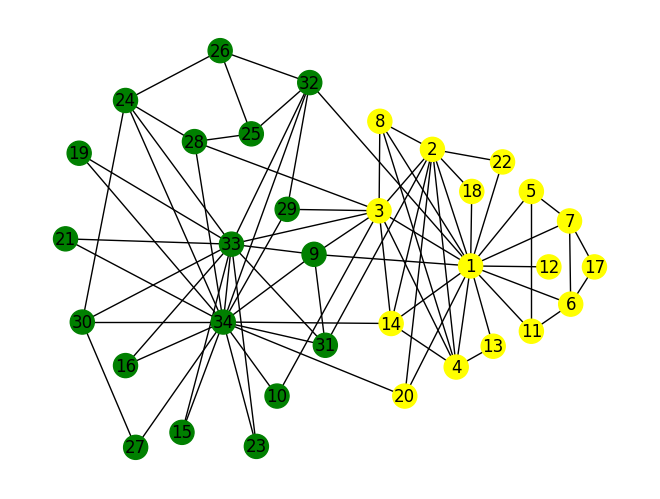

Computed Modularities
Q0: 0.37147 	 Q1: 0.37147


In [16]:
# Construct karate graph
karate = nx.Graph()
karate.add_edges_from([(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,11), (1,12), (1,13), (1,14), (1,18), (1,20), (1,22), (1,32), (2,3), (2,4), (2,8), (2,14), (2,18), (2,20), (2,22), (2,31), (3,4), (3,8), (3,9), (3,10), (3,14), (3,28), (3,29), (3,33), (4,8), (4,13), (4,14), (5,7), (5,11), (6,11), (6,17), (6,7), (7,17), (9,31), (9,33), (9,34), (10,34), (14,34), (15,33), (15,34), (16,33), (16,34), (19,33), (19,34), (20,34), (21,33), (21,34), (23,33), (23,34), (24,26), (24,28), (24,30), (24,33), (24,34), (25,26), (25,28), (25,32), (26,32), (27,30), (27,34), (28,34), (29,32), (29,34), (30,33), (30,34), (31,33), (31,34), (32,33), (32,34), (33,34)])
fixed_positions = {1:(10.74,4.07),2:(9.76,6.48),3:(8.39,5.21),4:(10.37,1.98),5:(12.30,5.61),6:(13.31,3.28),7:(13.28,5.00),8:(8.41,7.06),9:(6.72,4.31),10:(5.77,1.38),11:(12.30,2.72),12:(12.75,4.05),13:(11.32,2.41),14:(8.70,2.88),15:(3.33,0.63),16:(1.88,2.01),17:(13.92,4.05),18:(10.77,5.61),19:(0.69,6.40),20:(9.05,1.38),21:(0.34,4.63),22:(11.56,6.22),23:(5.24,0.34),24:(1.88,7.49),25:(5.11,6.80),26:(4.31,8.52),27:(2.14,0.32),28:(3.65,6.64),29:(6.03,5.24),30:(0.77,2.91),31:(7.01,2.43),32:(6.61,7.86),33:(4.60,4.52),34:(4.39,2.91)}
s   = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
sel = np.array([n-1 for n in karate]) 
s    = s[sel] # Reorder such that indices matches indices in networkx

node_col = ["yellow" if i == 1 else "green" for i in s]
nx.draw(karate,pos=fixed_positions, with_labels=True, node_color=node_col)
plt.show()

# Simple version
Q0 = s.T @ nx.modularity_matrix(karate) @ s  / (4 * karate.size())
Q1 = M_eq(karate, s)

assert np.allclose(Q0, Q1), "Modularity of Q0 (%.4f) and Q1 (%.4f) are not close" % (Q0, Q1)

print("Computed Modularities")
print("Q0: %.5f \t Q1: %.5f" % (Q0, Q1))

## Exercise 2: Limitations of Modularity
Having implemented Modularity function above, we can now try to stress test it a bit.

Below is some code that generate "cycle graphs" with cliques and computes the Modularity by your function `M_eq` from above.
The graphs generated vary in number of cliques and the size of the cliques.

We will observe, what happens to the Modularity score when we collapse cliques into larger clusters.

First run the following code and see an example of such a graph.

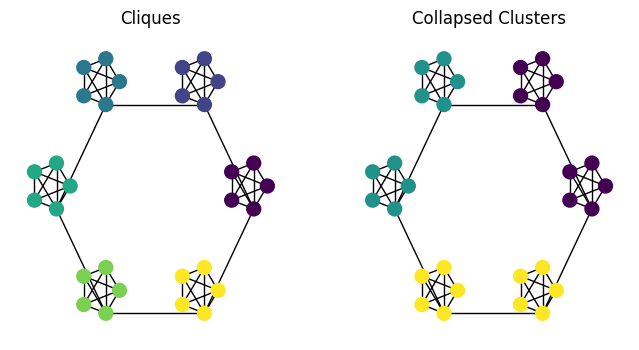

In [17]:
# Code for generating  cycles of cliques (See plots below.)
def clique_graph(cliques=8, sizes=4, radius=5):
    G = nx.Graph()
    pos = {}
    y = []
    
    # Compute circle offsets for plotting positions
    r = radius
    offsets = np.array([(np.cos(2.*r*np.pi/cliques), np.sin(2.*r*np.pi/cliques)) for r in range(cliques)]) * r
    
    # Add Cliques to the graph
    for clique, offset in enumerate(offsets):
        i_offset = clique * sizes
        mapping = {i: i_offset+i for i in range(sizes)}
        G_ = nx.complete_graph(sizes)
        G_ = nx.relabel_nodes(G_, mapping)
        
        p = nx.circular_layout(G_)
        for k in p.keys():
            p[k] += offset 
        
        G.add_nodes_from(G_.nodes)
        G.add_edges_from(G_.edges)
        pos = {**pos, **p}
        y += [clique] * sizes
        
    connections = [(i*sizes+(sizes-1), ((i+1)*sizes+(sizes-1))%G.order()) for i in range(cliques)]
    G.add_edges_from(connections)
    
    return G, pos, np.array(y)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
G, pos, y = clique_graph(6, 5) # 6 cliques of 5 nodes each
ax[0].set_title("Cliques")
ax[1].set_title("Collapsed Clusters")
nx.draw(G, pos=pos, ax=ax[0], node_color=y, node_size=100)
nx.draw(G, pos=pos, ax=ax[1], node_color=y//2, node_size=100)

Below we do the actual modularity computations on this kind of graphs.
In particular, we collapse cliques with their neighbors and those clusters with their neighbors and so on.

| Cliques    | Size       | Single     | Pairs      | Quads      | Octs       | 
-------------------------------------------------------------------------------
|         20 |          3 |    15.3972 |     3.8337 |     0.9346 |     0.2619 |
|         56 |          8 |   130.3183 |    32.5505 |     8.1014 |     1.9947 |
|          8 |         48 |     2.7319 |     0.6518 |     0.1308 |     0.0000 |


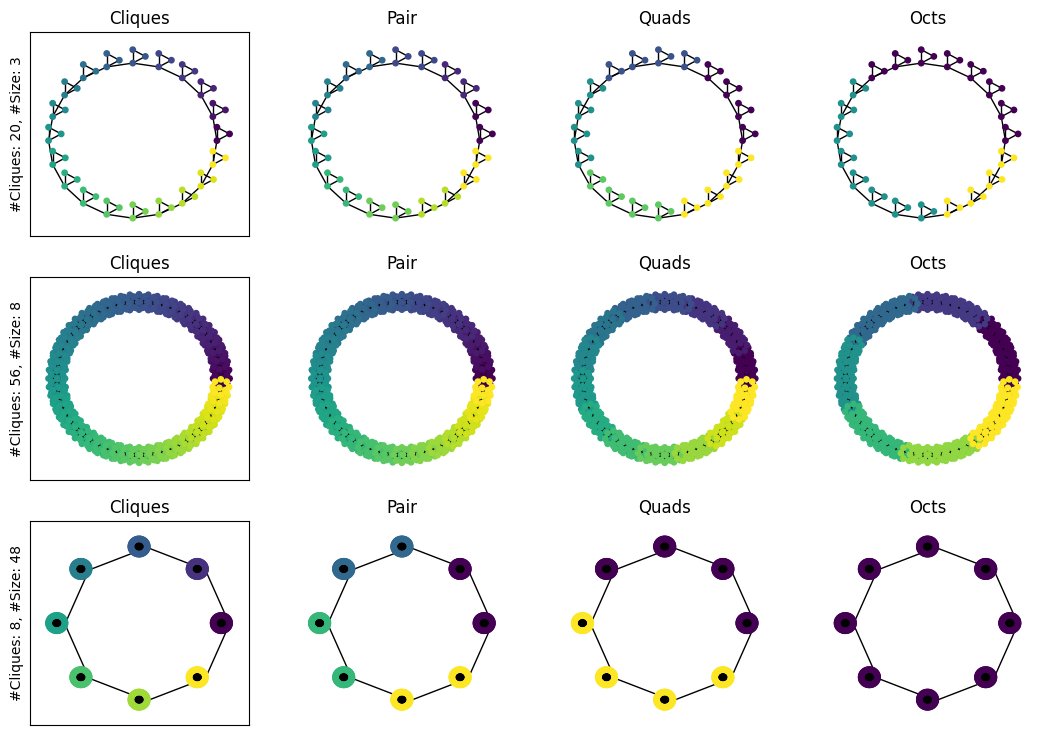

In [18]:
fig, ax = plt.subplots(3, 4, figsize=(13,9))
test_sizes = [(20, 3), (56, 8), (8, 48)]

modularities = []

for i, (c, s) in enumerate(test_sizes):
    G, pos, y = clique_graph(c, s, radius=10)
    
    # Plotting
    ax[i, 0].set_title("Cliques")
    ax[i, 0].set_ylabel("#Cliques: %d, #Size: %d" % (c, s))
    nx.draw(G, pos=pos, ax=ax[i, 0], node_size=15, node_color=y)
    ax[i, 0].set_axis_on()
    
    ax[i, 1].set_title("Pair")
    nx.draw(G, pos=pos, ax=ax[i, 1], node_size=15, node_color=y//2)
    ax[i, 2].set_title("Quads")
    nx.draw(G, pos=pos, ax=ax[i, 2], node_size=15, node_color=y//4)
    ax[i, 3].set_title("Octs")
    nx.draw(G, pos=pos, ax=ax[i, 3], node_size=15, node_color=y//8)

    # Computation of Modularity
    modularities.append([M_eq(G, y), M_eq(G, y//2), M_eq(G, y//4), M_eq(G, y//8)])

print(("| " + "%-10s | " * 6) % ("Cliques", "Size", "Single", "Pairs", "Quads", "Octs"))
print("-" * 79)
for (c, s), mod in zip(test_sizes, modularities):
    print("| " + "%10d | %10d | %10.4f | %10.4f | %10.4f | %10.4f |" % (c, s, *mod))

The S only have -1 and 1 but that does not fith with the graph which has more clusters ?  
Collpased means the clusters are worse than their natural cliques  

**Exercise 2.1:**  
1. In the graphs above, what would be the most natural "correct" clustering of the nodes?
2. Consider the output of the code above and describe what you observe. Is everything as you would expect?

## Exercise 3: Clique Percolation method
In this exercise, we will implement the Clique Percolation method for identifying (overlapping) communities.
Fill in the code below. The function `adjacent` returns `True` if two cliques of the same size are adjacent; feel free to use it.

1. Implement the algorithm below and test your algorithm below.
2. Try to do the smallest edit to the karate-graph to make the clique percolation method find only two communities for $K=4$.

In [19]:
def adjacent(l1, l2):
    l1_ = set(l1)
    l2_ = set(l2)
    
    k, k_ = len(l1_), len(l2_)
    if k != k_: return False
    
    l_  = l1_.union(l2_)
    return len(l_) == k+1

def clique_percolation(G, k=3):
    """
        args:
            G: A networkx graph
            k: size of cliques to use
        output:
            communities: list of communities; each community represented as a list of nodes 
            
        Example output:
            Two communitites. One community with node 1, 3, 6 and another with 1, 2, 4, 5.
            [ [1, 3, 6],  [1, 2, 4, 5] ]
    """
    communities = []
    # All cliques of size k in G
    cliques = [c for c in nx.enumerate_all_cliques(G) if len(c) == k]
    
    # TODO implement clique percolation algorithm
    if len(cliques) == 0: return []
    #start with a k-clique
    start = cliques[0]
    visited = [False] * len(cliques) 

    for other in cliques:
        if adjacent(start,other):
            #snflkr
            i=0
            
    
    while not all(visited):
        idx = [i for i,b in enumerate(visited) if not b]
        c = idx[np.random.choice(len(idx))] #pick random
        visited[c] = True

        #we add the clique to the full community 
        community = [cliques[c]]

        old_size = -1 #for first iteration
        size = len(community)
        while old_size != size: #as long as we find more stuff keep going
            for i, clique in enumerate(cliques):
                #check if part of the community first 
                if clique in community: continue

                for c in community:
                    if adjacent(c, clique):
                        community.append(clique)
                        visited[i] = True
                        break #finding one connection is enough so break
            old_size = size
            #we need to check again because a clique that was not adjacent before 
            # might have become adjacent with the new added clique

        communities.append(community)

    
    return communities

[[[9, 33, 34], [3, 9, 33], [9, 31, 33], [9, 31, 34], [32, 33, 34], [31, 33, 34], [33, 34, 15], [33, 34, 16], [33, 34, 19], [33, 34, 21], [33, 34, 23], [33, 34, 24], [33, 34, 30], [33, 24, 30], [34, 24, 30], [34, 30, 27]], [[1, 2, 4], [1, 2, 3], [1, 2, 8], [1, 2, 14], [1, 2, 18], [1, 2, 20], [1, 2, 22], [1, 3, 4], [1, 3, 8], [1, 3, 9], [1, 3, 14], [1, 4, 8], [1, 4, 13], [1, 4, 14], [2, 3, 4], [2, 3, 8], [2, 3, 14], [2, 4, 8], [2, 4, 14], [3, 4, 8], [3, 4, 14], [3, 9, 33], [9, 31, 33], [9, 31, 34], [9, 33, 34], [32, 33, 34], [31, 33, 34], [33, 34, 15], [33, 34, 16], [33, 34, 19], [33, 34, 21], [33, 34, 23], [33, 34, 24], [33, 34, 30], [33, 24, 30], [34, 24, 30], [34, 30, 27]], [[1, 6, 11], [1, 5, 11], [1, 6, 7], [6, 7, 17]], [[32, 26, 25]], [[1, 5, 7], [1, 5, 11], [1, 6, 7], [1, 6, 11], [6, 7, 17]], [[32, 29, 34], [32, 33, 34], [31, 33, 34], [33, 34, 15], [33, 34, 16], [33, 34, 19], [33, 34, 21], [33, 34, 23], [33, 34, 24], [33, 34, 30], [33, 24, 30], [34, 24, 30], [34, 30, 27]], [[28, 3

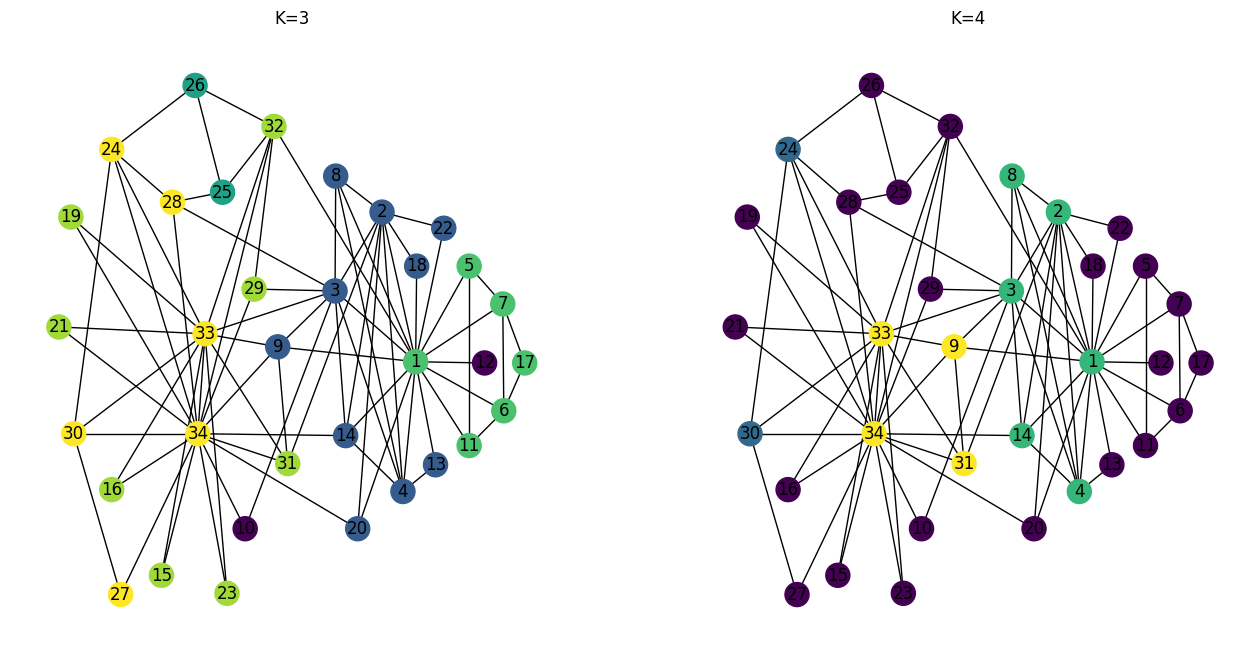

In [22]:
# Test of algorithm
def color_communities(communities, G):
    colors = {}
    for i, community in enumerate(communities):
        for cl in community:
            for idx in cl:
                colors[idx] = i
    return [colors[k] if k in colors else -1 for k in G]

# Testing code by plotting found communities
community1 = clique_percolation(karate, k=3)
community2 = clique_percolation(karate, k=4)
print(community1)

y3 = color_communities(community1, karate)
y4 = color_communities(community2, karate)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title("K=3")
nx.draw(karate,pos=fixed_positions, ax=ax[0], with_labels=True, node_color=y3)
ax[1].set_title("K=4")
nx.draw(karate,pos=fixed_positions, ax=ax[1], with_labels=True, node_color=y4)

In [ ]:
# Changing the Karate graph
karate2 = karate.__class__()
karate2.add_nodes_from(karate)
karate2.add_edges_from(karate.edges)

# TODO change `karate2` by adding or removing edges.

communities = clique_percolation(karate2, k=4)
y4          = color_communities(communities)
nx.draw(karate2, pos=fixed_positions, with_labels=True, node_color=y4)

## Exercise 4: BigClam 
In this exercise, we will be doing overlapping community detection with BigClam.
We will implement the log-likelihood function, the gradient function, and the iterative training.
Recall, that our model is going to be represented by a matrix $F \in \mathbb{R}^{n \times c}$, 
which has a row for each sample and a column for each community.

The log-likelihood is defined as follows:

$$
l\left(F_{u}\right)=\sum_{v \in \mathcal{N}(u)} \log \left(1-\exp \left(-F_{u} F_{v}^{T}\right)\right)-\sum_{v \notin \mathcal{N}(u)} F_{u} F_{v}^{T}
$$

and the associated gradient is

$$
\nabla l\left(F_{u}\right)=\sum_{v \in \mathcal{N}(u)} F_{v} \frac{\exp \left(-F_{u} F_{v}^{T}\right)}{1-\exp \left(-F_{u} F_{v}^{T}\right)}-\sum_{v \notin \mathcal{N}(u)} F_{v}
$$

Fill in the `TODO`s below and test your code.

In [56]:
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    ll = 0
    
    # TODO compute log-likelihood of full F
    # Fut = F @ F.T
    # print(F.shape)   
    # print(Fut.shape) 
    
    # luf = []
    # for u in range(F.shape[0]):
    #     sum1 = 0
    #     sum2 = 0
    #     # for v in range(F.shape[0]):
    #     ee = np.sum([ np.log2(1-np.exp(-np.dot(F[u],F[v]))) for v in range(F.shape[0]) if v!=u and A[u][v]==1])
    #     e2 = np.sum([ np.dot(F[u],F[v]) for v in range(F.shape[0]) if v!=u and A[u][v]!=1])
    #     luf.append(ee - e2)

    A_soft = F @ F.T
    neigbour_loss = ( A * np.log(1.-np.exp(-A_soft))  ).sum()
    non_nb_loss = ( (1-A) * A_soft ).sum() #there is magic here i dont understand



    # print(A)
      

    
    return neigbour_loss - non_nb_loss

def gradient(F, A, i):
    _, C = F.shape
    
    # TODO compute gradient of the i'th row of F
    # fu = F[i]
    # nbs = np.sum([ F[v]*((np.exp(-np.dot(fu,F[v])))/(1-np.exp(-np.dot(fu,F[v])))) for v in  range(F.shape[0]) if v!=i and A[i][v]==1 ])
    # non_nbs = np.sum([ F[v] for v in range(F.shape[0]) if v!=i and A[i][v]!=1])


    nbs_i = np.where(A[i]==1)
    print(nbs_i)
    non_nbs_i = np.where(1-A[i]==1)

    sum_nbs = np.zeros((C,))
    sum_nonbs = np.zeros((C,))

    for nb in nbs_i[0]:
        dotp = F[nb].dot(F[i])
        sum_nbs += F[nb]*sigm(dotp)

    for nnb in non_nbs_i[0]:
        sum_nonbs += F[nnb]
    
    grad = sum_nbs - sum_nonbs


    return grad

def train(A, C, epochs=100, lr=1e-3):
    n, _ = A.shape
    F = np.random.rand(n,C)

    # Gradient ascent on one note at a time
    loss = []
    for e in range(epochs): 
        for node_idx in range(n):
            
            grad = gradient(F, A, node_idx)
            
            # Gradient step
            F[node_idx] += lr * grad
            # Projection
            F[node_idx] = np.maximum(0.001, F[node_idx]) 
            
        ll = log_likelihood(F, A) # Used for plotting loss
        loss.append(ll)
        print('\rAt step %5i/%5i ll is %5.3f'%(e, epochs, ll), end="")
        
    print()
    return F, loss

In the code below you can try your implementation of the BigClam algorithm on different toy graphs.
You can choose from 7 different graphs.

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)
(array([0, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)
(array([0, 1, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)
(array([0, 1, 2, 4, 5, 6, 7, 8, 9], dtype=int64),)
(array([0, 1, 2, 3, 5, 6, 7, 8, 9], dtype=int64),)
(array([0, 1, 2, 3, 4, 6, 7, 8, 9], dtype=int64),)
(array([0, 1, 2, 3, 4, 5, 7, 8, 9], dtype=int64),)
(array([0, 1, 2, 3, 4, 5, 6, 8, 9], dtype=int64),)
(array([0, 1, 2, 3, 4, 5, 6, 7, 9], dtype=int64),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 19, 59], dtype=int64),)
(array([11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int64),)
(array([10, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int64),)
(array([10, 11, 13, 14, 15, 16, 17, 18, 19], dtype=int64),)
(array([10, 11, 12, 14, 15, 16, 17, 18, 19], dtype=int64),)
(array([10, 11, 12, 13, 15, 16, 17, 18, 19], dtype=int64),)
(array([10, 11, 12, 13, 14, 16, 17, 18, 19], dtype=int64),)
(array([10, 11, 12, 13, 14, 15, 17, 18, 19], dtype=int64),)
(array([10, 11, 12, 13, 14, 15, 16, 18, 19], dtype=in

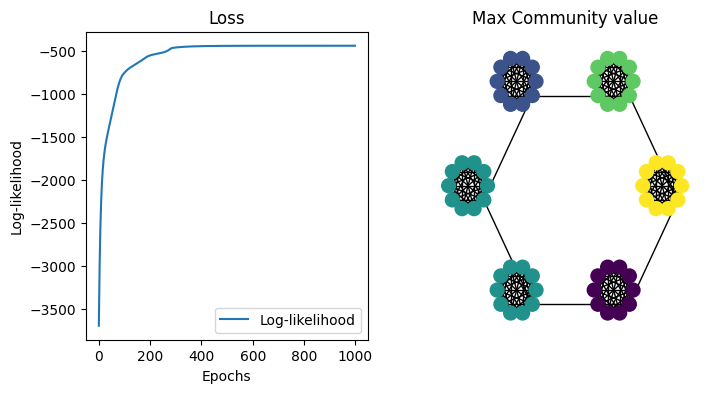

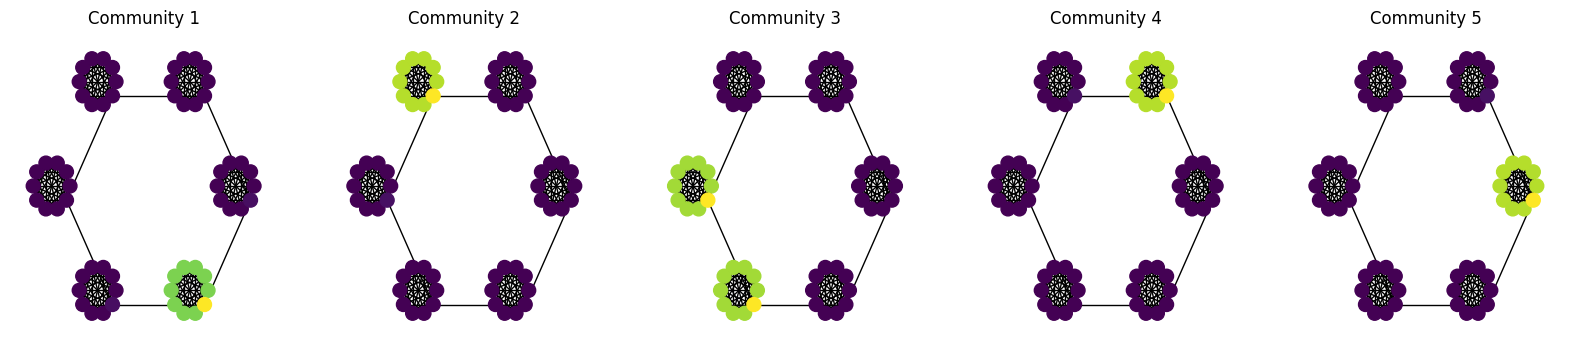

In [57]:
# Cliques
G_clique, pos_clique, y = clique_graph(6, 10, radius=5)

# Tiny
G_tiny = nx.Graph()
G_tiny.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 3)])

# Other graphs
K_20      = nx.complete_graph(20)
K_5_7    = nx.complete_bipartite_graph(5,7)
barbell  = nx.barbell_graph(10,10)
lollipop = nx.lollipop_graph(10,20)

# Options for graphs:
options = {
    'karate':    {'C': 2, 'G': karate,   'pos': fixed_positions},
    'cliques':   {'C': 5, 'G': G_clique, 'pos': pos_clique},
    'tiny':      {'C': 2, 'G': G_tiny,   'pos': None},
    'complete':  {'C': 3, 'G': K_20,     'pos': None},
    'bipartite': {'C': 2, 'G': K_5_7,    'pos': None},
    'barbell':   {'C': 3, 'G': barbell,  'pos': None},
    'lollipop':  {'C': 2, 'G': lollipop, 'pos': None},
}

choose = 'cliques'
G, C, pos = options[choose]['G'], options[choose]['C'], options[choose]['pos']

A = nx.adjacency_matrix(G).todense()
F, loss = train(A, C, 1000, 1e-3)

# Plot max communitise for each node
y = np.argmax(F, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(loss, label="Log-likelihood")
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Log-likelihood")

ax[1].set_title("Max Community value")
nx.draw(G, pos=pos, ax=ax[1], node_color=y, node_size=100)

# Visualize each individual community identified
fig, ax = plt.subplots(1, C, figsize=(C*4, 4))
for c in range(C):
    ax[c].set_title("Community %d" % (c+1))
    nx.draw(G, pos=pos, ax=ax[c], node_color=F[:,c], node_size=100)